# 09 향후 판매량 예측
* 대회명
    * [Predict Future Sales](https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales)
    * https://www.kaggle.com/competitions/   competitive-data-science-predict-future-sales
        * Final project for "How to win a data science competition" Coursera course
* 미션 : 2013년 1월부터 2015년 10월까지 판매 데이터를 기반으로 2015년 11월 판매량 예측
* 문제 유형 : 회귀
* 평가지표 : RMSE
* 사용한 모델 : LightGBM
* 탐색적 데이터 분석
    * 데이터 병합
    * 그룹화
* 피처 엔지니어링
    * 피처명 한글화
    * 데이터 다운캐스팅
    * 조합
    * 이어 붙이기
    * 병합
    * 이상치 제거
    * 파생 피처 생성
## 9.1 경진대회 이해
* 데이터 의미
    * sales_train : 2013년 1월부터 2015년 10월까지 일별 판매 내역
    * shops : 상점에 관한 추가 정보
    * items : 상품에 관한 추가 정보
    * item_categories : 상품분류에 관한 추가 정보
    * test : 테스트 데이터(2015년 11월 각 상점의 상품별 월간 판매량 예측)
    * sample_submission : 샘플 제출 파일
* target
    * 각 상점의 상품별 월간 판매량 예측
* 주의 사항
    * 각 상점의 상품별 월간 판매량은 0~20개 사이여야 함

## 9.2 탐색적 데이터 분석
### 9.2.1 데이터 둘러보기

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
data_path = '../../data/09_sales/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [3]:
# slaes_train 데이터
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


* 분석 결과
    * 상품의 가격은 그 당시의 가격
    * 타깃값 = `shop_id - item_id - date_block_num`을 그룹화 한 후 item_cnt_day의 합

In [5]:
sales_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


* 분석결과
    * 메모리 관리 필요
    * 2013년 1월부터 2015년 9월까지 판매 내역을 훈련데이터로 사용
    * 2015년 10월 판매내역을 검증 데이터로 사용

In [6]:
# shops 데이터
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


* 분석 결과
    * 상점 이름의 첫 단어는 도시를 뜻함
    * shop_id를 기준으로 sales_train과 shops 병합

In [7]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [8]:
# items 데이터
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


* 분석 결과
    * 상품명 피처 제거
    * item_id를 기준으로 sales_train과 items 병합

In [9]:
# item_categories.head()
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


* 분석 결과
    * item_category_id를 기준으로 sales_train과 items_categories 병합
    * 상품분류명에서 첫 단어는 대분류

In [10]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [11]:
# 테스트 데이터
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [13]:
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [15]:
# 데이터 병합
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


In [16]:
# 피처 요약표 만들기
def resume_table(df):
    print(f'데이터셋 형상 : {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index': '피쳐'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고유값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values
    return summary

resume_table(train)

데이터셋 형상 : (2935849, 10)


,피쳐,데이터 타입,결측값 개수,고유값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


* resume 분석
    * shop_id - shop_name 1:1 매칭
    * item_id - item_name 1:1 매칭
    * item_category_id - item_category_name 1:1 매칭

### 9.2.2 데이터 시각화

<Axes: ylabel='item_cnt_day'>

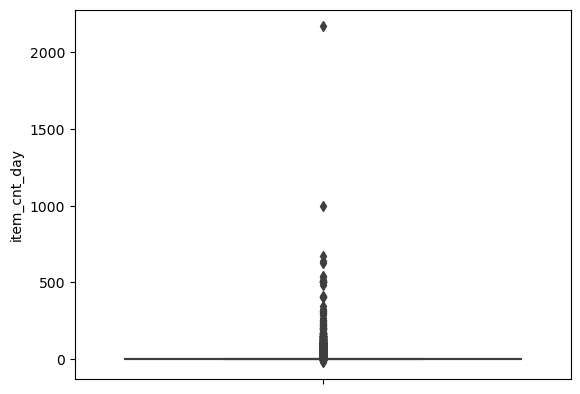

In [18]:
# 일별 판매량
sns.boxplot(data=train, y='item_cnt_day')

* 일별 판매량 1000이상 데이터 제거

<Axes: ylabel='item_price'>

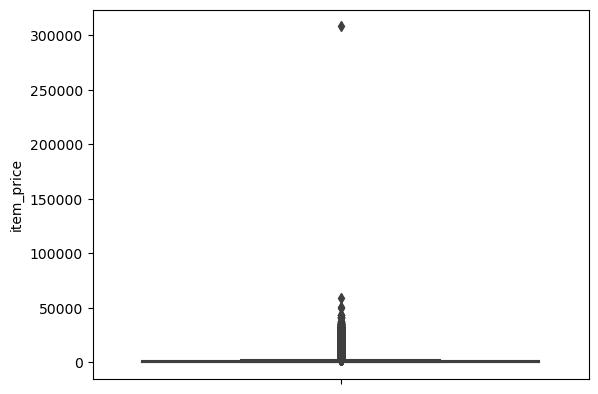

In [19]:
# 판매가(상품 가격)
sns.boxplot(data=train, y='item_price')

* 판매가에서 50000이상 데이터 제거

In [21]:
# 그룹화
# group = train.groupby('date_block_num')['item_cnt_day'].sum()
group = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


[Text(0.5, 1.0, 'Distribution of monthly item counts by date block number'),
 Text(0.5, 0, 'Date block number'),
 Text(0, 0.5, 'Monthly item counts')]

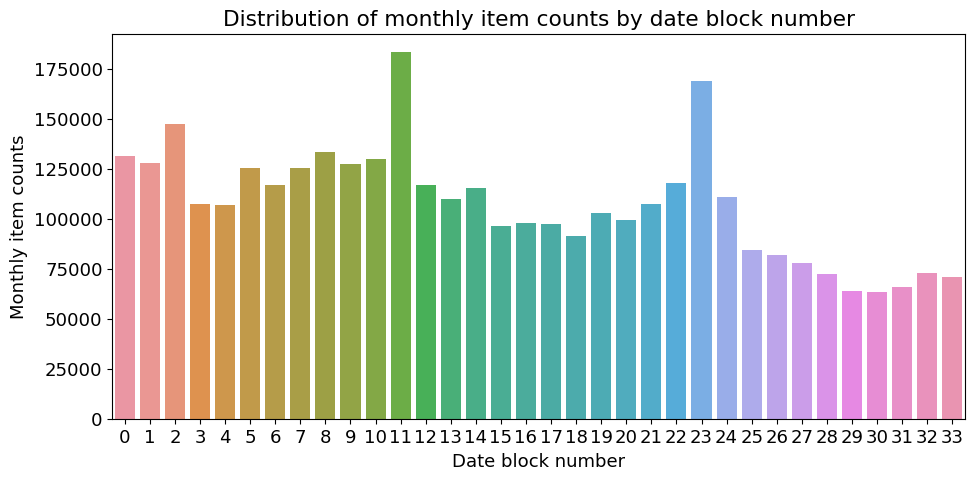

In [22]:
# 월별 판매량
mpl.rc('font', size=13)
figure, ax = plt.subplots()
figure.set_size_inches(11,5)

group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(data=group_month_sum, x='date_block_num', y='item_cnt_day')
ax.set(
    title='Distribution of monthly item counts by date block number',
    xlabel='Date block number',
    ylabel='Monthly item counts',
)

In [24]:
# 상품 분류별 판매량
train['item_category_id'].nunique()

84

In [27]:
group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day': 'sum'})
group_cat_sum = group_cat_sum.reset_index()
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_day']>10000]
group_cat_sum

,item_category_id,item_cnt_day
2,2,19597.0
3,3,29807.0
6,6,20472.0
8,8,13699.0
9,9,18118.0
12,12,13230.0
19,19,254887.0
20,20,127319.0
21,21,33066.0
22,22,25123.0


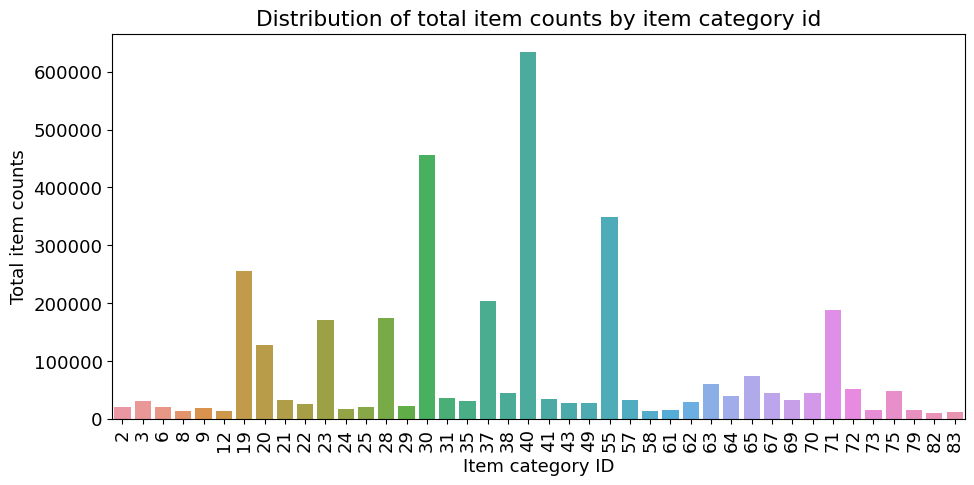

In [30]:
figure, ax = plt.subplots()
figure.set_size_inches(11,5)
sns.barplot(data=group_cat_sum, x='item_category_id', y='item_cnt_day')
ax.set(
    title='Distribution of total item counts by item category id',
    xlabel='Item category ID',
    ylabel='Total item counts'
)
ax.tick_params(axis='x', labelrotation=90)

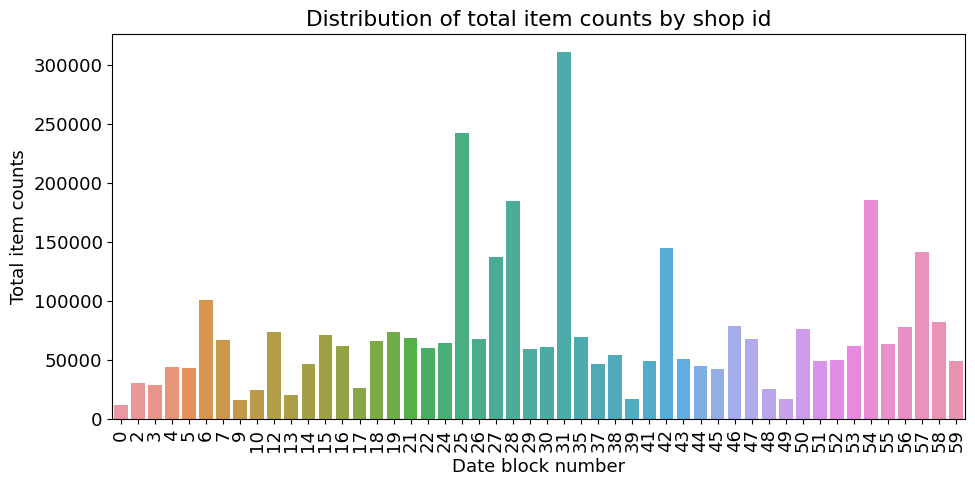

In [31]:
# 상점별 판매량
figure, ax = plt.subplots()
figure.set_size_inches(11,5)
group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_day'] > 10000]

sns.barplot(data=group_shop_sum, x='shop_id', y='item_cnt_day')
ax.set(
    title='Distribution of total item counts by shop id',
    xlabel='Date block number',
    ylabel='Total item counts'
)
ax.tick_params(axis='x', labelrotation=90)

### 분석 정리 및 모델링 전략
* 분석 정리
    * 타깃값은 0~20 사이로 제한
    * 시계열 데이터이므로 데이터 순서 주의
        * OOF 예측 등 데이터 순서가 무시되는 기법은 사용할 수 없음
        * 검증 데이터는 훈련 데이터 중 가장 최근 1개월치 이용
    * 타깃값
        * 월별 판매량 예측
        * 주어진 데이터는 일별 판매량만 있으므로 일별 판매량을 합쳐서 타깃값으로 활용
    * 데이터 병합
    * 메모리 관리 필요
    * 파생 피처 추가
        * 상점명과 상품분류명의 첫 단어는 각각 도시와 대분류를 뜻함
    * 피처 제거
        * date 피처 제거
    * 이상치 제거
        * 일별 판매량과 판매가에서 값이 과한 데이터 제거
    * 모든 데이터에서 결측값이 없음
* 모델링 전략
    * 베이스라인 모델 : LightGBM
        * 피처 엔지니어링 : 피처명 한글화, 데이터 다운캐스팅, 데이터 조합 생성, 타깃값 추가
    * 성능 개선 : LightGBM
        * 피처 엔지니어링 : 이상치 제거, 전차리 등 다양한 파생 피처 추가, 인코딩, 결측값 처리